# Кусовая работа студента группы 1365
## Тараданова Николая

### Импорт библиотек, файлов и настройка вывода


In [284]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams.update({'font.size': 14})

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import plotly.graph_objects as go
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

In [220]:
PATH_TO_TRAIN = 'data/train.csv'
PATH_TO_TEST = 'data/test.csv'

 Использую 3 набора, т.е. разделю тест на тренировочный и тестовые наборы

In [221]:
train_df = pd.read_csv(PATH_TO_TRAIN)

X = train_df.drop(['Price'], axis=1)
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

test_df = pd.read_csv(PATH_TO_TEST)
pass


### Используемые функции


In [222]:
def add_columns(dataframe, column_name):
    df = pd.get_dummies(dataframe[column_name])
    for name in df.columns:
        df.rename(columns={name : column_name + '_' + name}, inplace=True)
    dataframe[df.columns] = df
    dataframe.drop([column_name], axis=1, inplace=True)

In [223]:

def display_components_in_cool_3D_space(components, y_train, component1, component2, component3, label='Price'):
    components_with_labels_df = pd.concat([components, y_train], axis=1)
    fig = go.Figure(data=[go.Scatter3d(
        x=components_with_labels_df[component1],
        y=components_with_labels_df[component2],
        z=components_with_labels_df[component3],
        mode='markers',
        marker=dict(
            size=5,
            color=components_with_labels_df[label],
            colorscale='jet',
            colorbar=dict(thickness=10),
            line=dict(width=2, color='DarkSlateGrey')
        )
    )])

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title=component1,
            yaxis_title=component2,
            zaxis_title=component3),
    )

    fig.show()

In [224]:
def apply_elbow_method(X):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(sum(np.min(cdist(X,
                                            kmeanModel.cluster_centers_,
                                            'euclidean'),
                                      axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k');

In [225]:
def reduce_dims_to_2D_space_with_PCA(df):
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])

def reduce_dims_to_3D_space_with_PCA(df):
    pca = PCA(n_components=3)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def reduce_dims_to_2D_space_with_TSNE(df):
    tsne = TSNE(n_components=2, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])

def reduce_dims_to_3D_space_with_TSNE(df):
    tsne = TSNE(n_components=3, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    if labels is not None:
        if labels.nunique() > 10:
            p = ax.scatter(components_with_labels_df['component_1'],
                           components_with_labels_df['component_2'],
                           components_with_labels_df['component_3'],
                           c=labels, cmap=plt.get_cmap('jet'), alpha=0.5)
        else:
            p = ax.scatter(components_with_labels_df['component_1'],
                           components_with_labels_df['component_2'],
                           components_with_labels_df['component_3'],
                           c=labels, cmap=plt.get_cmap('jet', labels.nunique()), alpha=0.5)
    else:
        p = ax.scatter(components_with_labels_df['component_1'],
                       components_with_labels_df['component_2'],
                       components_with_labels_df['component_3'],
                       alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    ax.set_title('3D mapping of objects')
    fig.colorbar(p);

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        if labels.nunique() > 10:
            p = components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                               c=labels.name, cmap=plt.get_cmap('jet'),
                                               alpha=0.5, figsize=(12, 6), sharex=False)
        else:
            p = components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                               c=labels.name, cmap=plt.get_cmap('jet', labels.nunique()),
                                               alpha=0.5, figsize=(12, 6), sharex=False)
    else:
        p = components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                           alpha=0.5, figsize=(12, 6))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects');

def display_clusters_distribution(unique_labels, labels_counts):

    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution');

In [226]:
def evaluate_preds(true_values_train, pred_values_train, true_values_test, pred_values_test):
    print('Train:\t' + 'R2 = ' + str(round(r2_score(true_values_train, pred_values_train), 4)) +
          '\tMAE = ' + str(round(mean_absolute_error(true_values_train, pred_values_train), 3)) +
          '\n' +
          'Test:\t' + 'R2 = ' + str(round(r2_score(true_values_test, pred_values_test), 4)) +
          '\tMAE = ' + str(round(mean_absolute_error(true_values_test, pred_values_test), 3))
          )

    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    sns.scatterplot(x=pred_values_train, y=true_values_train)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train: True vs Predicted values');

    plt.subplot(122)
    sns.scatterplot(x=pred_values_test, y=true_values_test)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test: True vs Predicted values');

# Первый взгляд

In [227]:
X_train.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4901  13295           1    1.0  39.248800         NaN            0.0      9   
4375   3756          61    2.0  56.053580   33.929772            8.0      8   
6698  15429          13    1.0  41.009788   23.960289            8.0      3   
9805   7238           9    2.0  63.640480   58.149243            1.0      3   
1101  13604          90    1.0  49.327912   20.992250           12.0     15   
9537   2253           1    3.0  89.397275   85.959266            1.0      9   
7655   7846          79    2.0  42.090330   27.413836            5.0      2   
5235   1694          29    2.0  59.031566   36.372927           10.0     20   
5165   7897         109    2.0  44.514341   28.068914            5.0      8   
118   14822          18    3.0  76.235137   47.001817           10.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4901        17.0       1977   0.007122         B         B         1   
4375        12.0       1986   0.300323         B         B        52   
6698        14.0       1997   0.090799         B         B        74   
9805         1.0       1977   0.161532         B         B        25   
1101        23.0       2008   0.246032         B         A        22   
9537        22.0       1977   0.007122         B         B         1   
7655         5.0       1964   0.169091         B         B        19   
5235        22.0       2002   0.069660         B         B        31   
5165         9.0       1965   0.000000         B         B        25   
118         17.0       1997   0.000000         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4901       264         0           NaN            0        1       B  
4375     10311         6           NaN            1        9       B  
6698     19083         2           NaN            5       15       B  
9805      5648         1          30.0            2        4       B  
1101      3151         4        2715.0            3        3       B  
9537       264         0           NaN            0        1       B  
7655      3856        10           NaN            2        5       B  
5235      6119         4           NaN            1        2       B  
5165      5027         4          46.0            1        1       B  
118       5562         0           NaN            0        5       A

In [228]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 4901 to 7270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7500 non-null   int64  
 1   DistrictId     7500 non-null   int64  
 2   Rooms          7500 non-null   float64
 3   Square         7500 non-null   float64
 4   LifeSquare     5906 non-null   float64
 5   KitchenSquare  7500 non-null   float64
 6   Floor          7500 non-null   int64  
 7   HouseFloor     7500 non-null   float64
 8   HouseYear      7500 non-null   int64  
 9   Ecology_1      7500 non-null   float64
 10  Ecology_2      7500 non-null   object 
 11  Ecology_3      7500 non-null   object 
 12  Social_1       7500 non-null   int64  
 13  Social_2       7500 non-null   int64  
 14  Social_3       7500 non-null   int64  
 15  Healthcare_1   3886 non-null   float64
 16  Helthcare_2    7500 non-null   int64  
 17  Shops_1        7500 non-null   int64  
 18  Shops

In [229]:
X_train.describe().T

count         mean            std          min          25%  \
Id             7500.0  8368.529067    4858.185603     0.000000  4165.750000   
DistrictId     7500.0    50.441733      43.700617     0.000000    19.000000   
Rooms          7500.0     1.887600       0.840234     0.000000     1.000000   
Square         7500.0    56.262165      20.337193     2.377248    41.748189   
LifeSquare     5906.0    37.438158      98.726068     0.370619    22.838608   
KitchenSquare  7500.0     6.417333      32.870226     0.000000     1.000000   
Floor          7500.0     8.502800       5.236619     1.000000     4.000000   
HouseFloor     7500.0    12.634400       6.833644     0.000000     9.000000   
HouseYear      7500.0  4658.735867  231517.756849  1912.000000  1974.000000   
Ecology_1      7500.0     0.117437       0.118195     0.000000     0.017647   
Social_1       7500.0    24.736133      17.627507     0.000000     6.000000   
Social_2       7500.0  5361.467467    4021.616228   168.000000  1564.000000   
Social_3       7500.0     8.027733      23.825236     0.000000     0.000000   
Healthcare_1   3886.0  1129.527535    1015.975294     0.000000   325.000000   
Helthcare_2    7500.0     1.309467       1.488576     0.000000     0.000000   
Shops_1        7500.0     4.259200       4.819673     0.000000     1.000000   

                       50%           75%           max  
Id             8378.500000  12540.250000  1.679600e+04  
DistrictId       35.000000     75.000000  2.090000e+02  
Rooms             2.000000      2.000000  1.900000e+01  
Square           52.539538     65.980391  6.047060e+02  
LifeSquare       32.837997     45.069982  7.480592e+03  
KitchenSquare     6.000000      9.000000  2.014000e+03  
Floor             7.000000     12.000000  4.200000e+01  
HouseFloor       14.000000     17.000000  1.170000e+02  
HouseYear      1977.000000   2001.000000  2.005201e+07  
Ecology_1         0.072158      0.194489  5.218671e-01  
Social_1         25.000000     36.000000  7.400000e+01  
Social_2       5285.000000   7287.000000  1.908300e+04  
Social_3          2.000000      5.000000  1.410000e+02  
Healthcare_1    900.000000   1547.750000  4.849000e+03  
Helthcare_2       1.000000      2.000000  6.000000e+00  
Shops_1           3.000000      6.000000  2.300000e+01

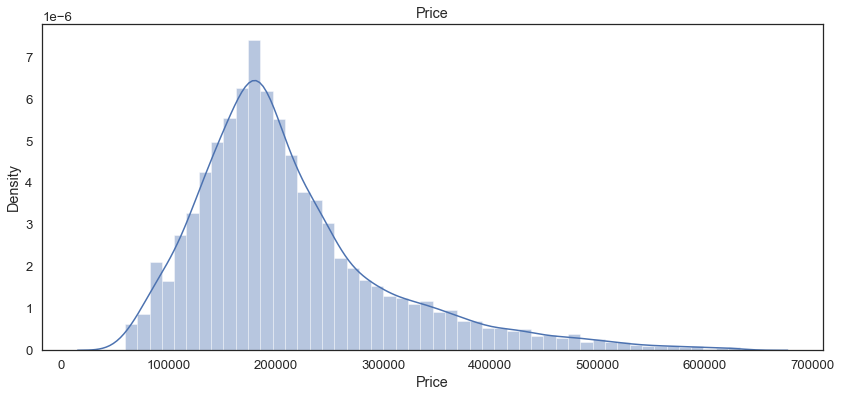

In [230]:
plt.figure(figsize = (14, 6))

sns.distplot(train_df['Price'])
plt.title('Price');

### Фича 'Healthcare' заполнена на 52%, принимаю решение исключить её из набора

In [231]:
X_train.drop(['Healthcare_1'], axis=1, inplace=True)
X_test.drop(['Healthcare_1'], axis=1, inplace=True)
test_df.drop(['Healthcare_1'], axis=1, inplace=True)

### Выбираю все фичи 'object'

In [232]:
feature_object_names = X_train.select_dtypes(include='object').columns.tolist()
feature_object_names

['Ecology_2', 'Ecology_3', 'Shops_2']

In [233]:
X_train['Ecology_2'].value_counts()

B    7430
A      70
Name: Ecology_2, dtype: int64

In [234]:
X_train['Ecology_3'].value_counts()

B    7289
A     211
Name: Ecology_3, dtype: int64

In [235]:
X_train['Shops_2'].value_counts()

B    6877
A     623
Name: Shops_2, dtype: int64

In [236]:
X_train.loc[X_train['LifeSquare'].isna(), 'LifeSquare'] = X_train['Square'] - X_train['KitchenSquare']
X_test.loc[X_test['LifeSquare'].isna(),   'LifeSquare'] = X_test['Square']  - X_test['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

### Преобразую признаки 'Ecology_2', 'Ecology_3', 'Shops_2' в бинарные

In [237]:
add_columns(X_train, 'Ecology_2')
add_columns(X_train, 'Ecology_3')
add_columns(X_train, 'Shops_2')

add_columns(X_test, 'Ecology_2')
add_columns(X_test, 'Ecology_3')
add_columns(X_test, 'Shops_2')

add_columns(test_df, 'Ecology_2')
add_columns(test_df, 'Ecology_3')
add_columns(test_df, 'Shops_2')


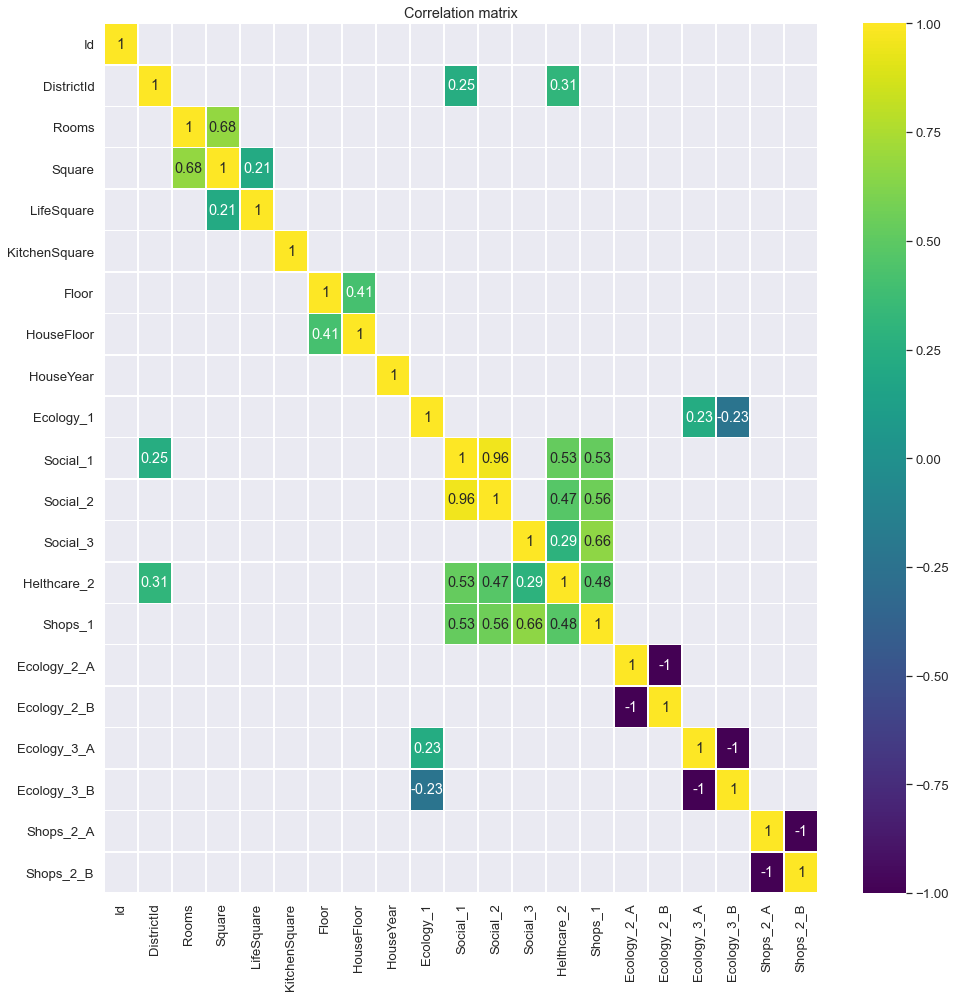

In [238]:
plt.figure(figsize = (16,16))
sns.set(font_scale=1.2)

corr_matrix = X_train.corr()
sns.heatmap(corr_matrix[abs(corr_matrix) >= 0.2], annot=True, linewidths=.5, cmap='viridis')

plt.title('Correlation matrix');

### Посмотрю на числовые фичи

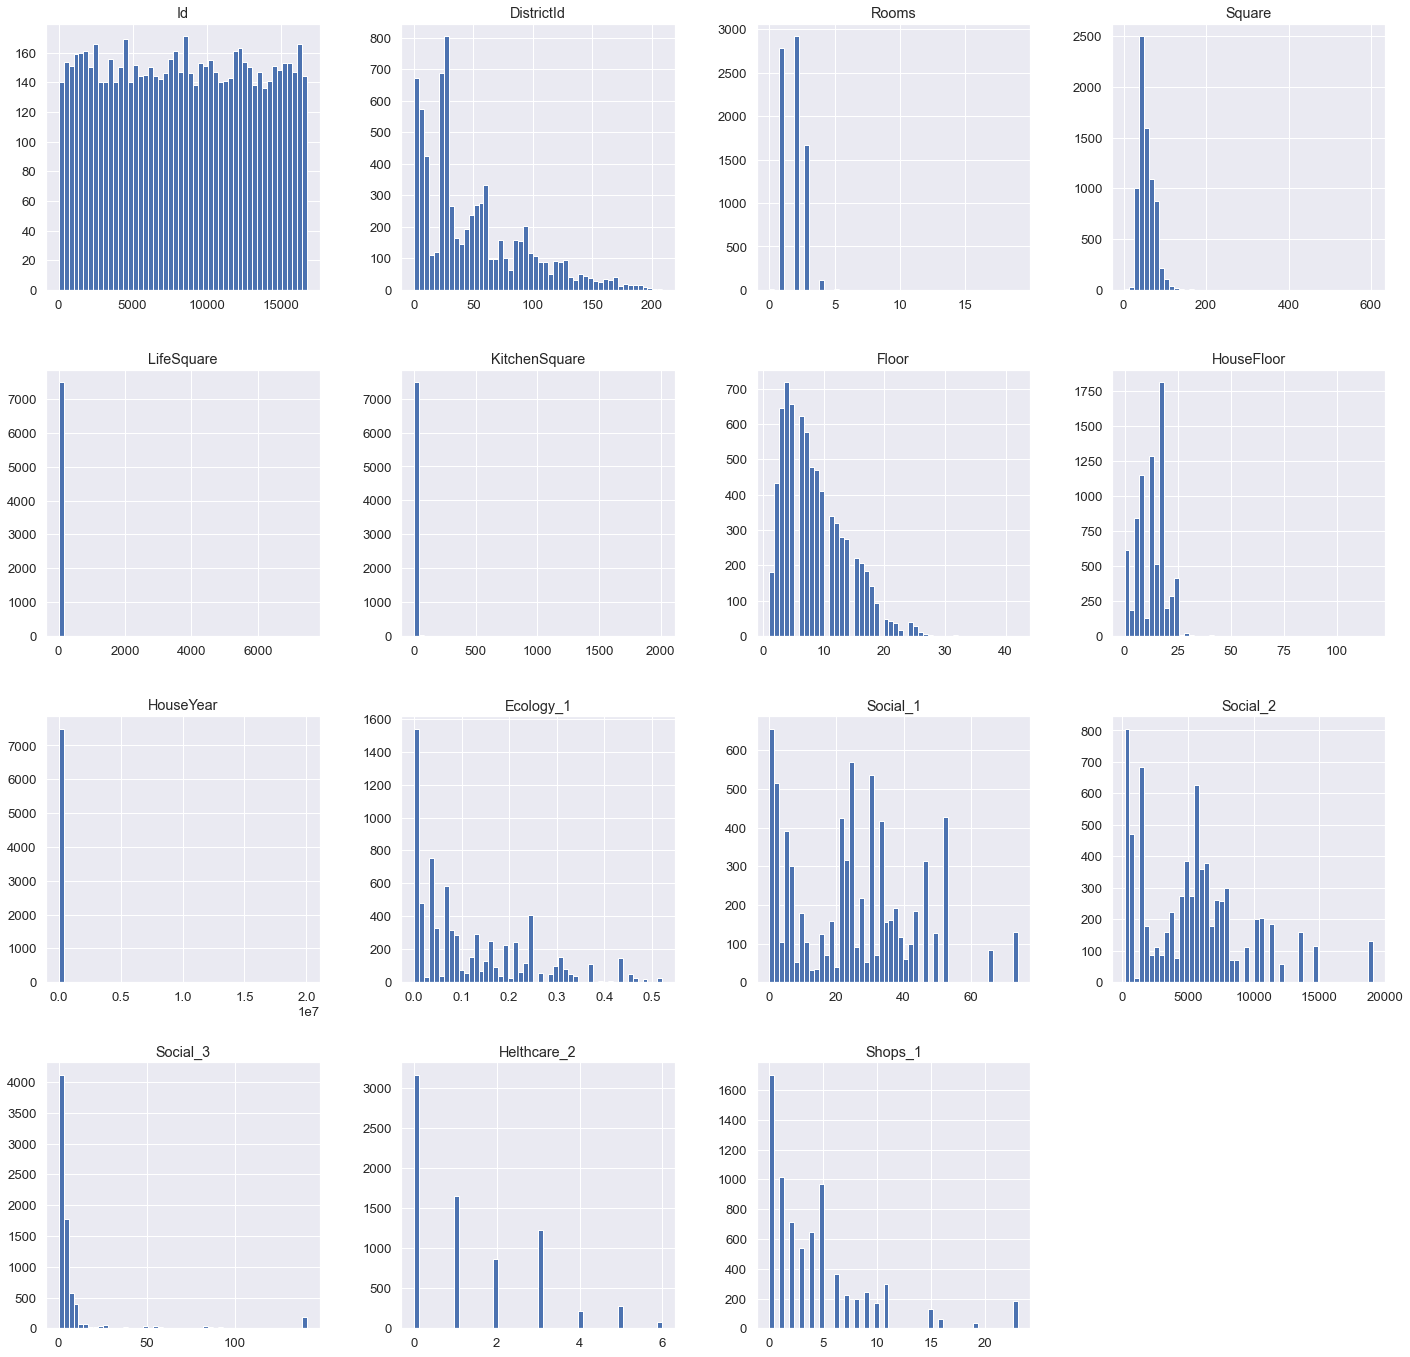

In [239]:
features = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
X_train[features].hist(figsize=(24,24), bins=50, grid=True);

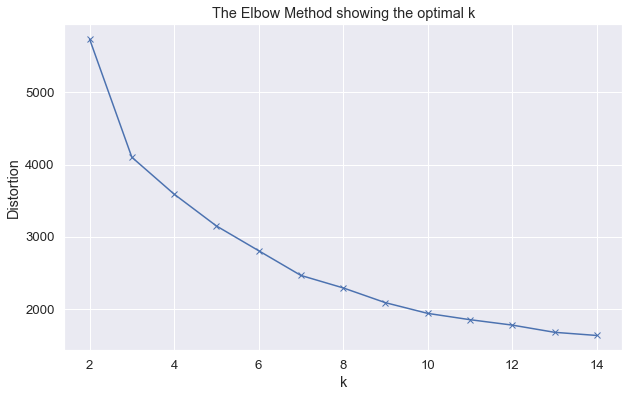

In [240]:
apply_elbow_method(X_train)

In [244]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)
features = X_train_scaled.iloc[:, :]
features_test = X_test_scaled.iloc[:, :]

In [246]:
components_2d_pca = reduce_dims_to_2D_space_with_PCA(features)

### На диаграмме хорошо различаются группы значений, кластеризую данные

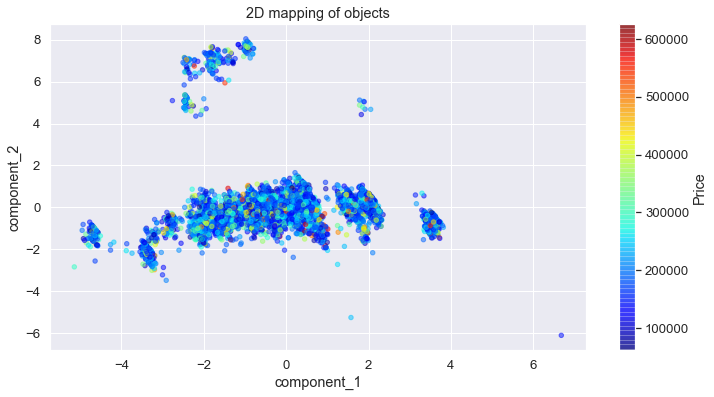

In [247]:
display_components_in_2D_space(components_2d_pca, y_train)

In [248]:
components_3d_pca = reduce_dims_to_3D_space_with_PCA(features)
components_3d_pca_test = reduce_dims_to_3D_space_with_PCA(features_test)

### В 3D группы прослеживаются отчетливее

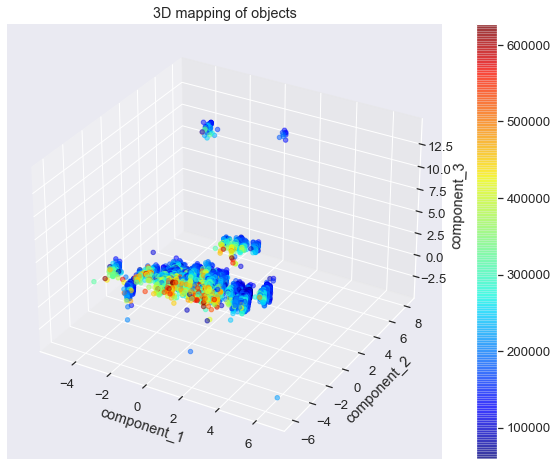

In [249]:
display_components_in_3D_space(components_3d_pca, y_train)

In [250]:
# Красивое, но в DataSpell не отображается)
display_components_in_cool_3D_space(components_3d_pca, y_train,  'component_1', 'component_2', 'component_3')

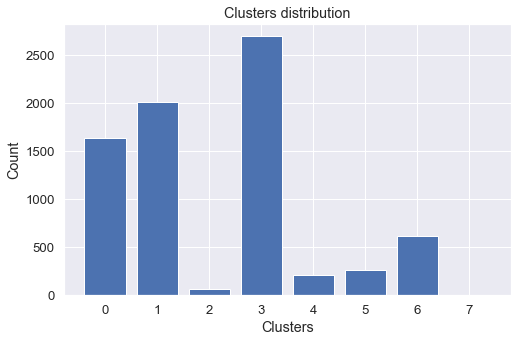

In [252]:
kmeans = KMeans(n_clusters=8, random_state=42)
labels_clast_train = kmeans.fit_predict(features)
labels_clast_train = pd.Series(labels_clast_train, name='clusters')

unique, counts = np.unique(labels_clast_train, return_counts=True)
display_clusters_distribution(unique, counts)

In [253]:
display_components_in_cool_3D_space(components_3d_pca, labels_clast_train, 'component_1', 'component_2', 'component_3', 'clusters')

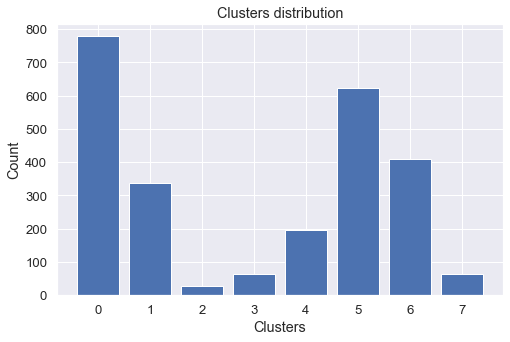

In [254]:
kmeans = KMeans(n_clusters=8, random_state=42)
labels_clast_test = kmeans.fit_predict(features_test)
labels_clast_test = pd.Series(labels_clast_test, name='clusters')

unique, counts = np.unique(labels_clast_test, return_counts=True)
display_clusters_distribution(unique, counts)

### Распределение в тестовом наборе совпадает

In [255]:
display_components_in_cool_3D_space(components_3d_pca_test, labels_clast_test, 'component_1', 'component_2', 'component_3', 'clusters')

Добавлю новый признак

In [256]:
X_train_ext = pd.concat([X_train.reset_index(),
                         labels_clast_train], axis=1)
X_train_ext.set_index('index', inplace=True)
X_train_ext.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
index                                                                          
4901   13295           1    1.0  39.248800   39.248800            0.0      9   
4375    3756          61    2.0  56.053580   33.929772            8.0      8   
6698   15429          13    1.0  41.009788   23.960289            8.0      3   
9805    7238           9    2.0  63.640480   58.149243            1.0      3   
1101   13604          90    1.0  49.327912   20.992250           12.0     15   
9537    2253           1    3.0  89.397275   85.959266            1.0      9   
7655    7846          79    2.0  42.090330   27.413836            5.0      2   
5235    1694          29    2.0  59.031566   36.372927           10.0     20   
5165    7897         109    2.0  44.514341   28.068914            5.0      8   
118    14822          18    3.0  76.235137   47.001817           10.0      9   

       HouseFloor  HouseYear  Ecology_1  ...  Social_3  Helthcare_2  Shops_1  \
index                                    ...                                   
4901         17.0       1977   0.007122  ...         0            0        1   
4375         12.0       1986   0.300323  ...         6            1        9   
6698         14.0       1997   0.090799  ...         2            5       15   
9805          1.0       1977   0.161532  ...         1            2        4   
1101         23.0       2008   0.246032  ...         4            3        3   
9537         22.0       1977   0.007122  ...         0            0        1   
7655          5.0       1964   0.169091  ...        10            2        5   
5235         22.0       2002   0.069660  ...         4            1        2   
5165          9.0       1965   0.000000  ...         4            1        1   
118          17.0       1997   0.000000  ...         0            0        5   

       Ecology_2_A  Ecology_2_B  Ecology_3_A  Ecology_3_B  Shops_2_A  \
index                                                                  
4901             0            1            0            1          0   
4375             0            1            0            1          0   
6698             0            1            0            1          0   
9805             0            1            0            1          0   
1101             0            1            1            0          0   
9537             0            1            0            1          0   
7655             0            1            0            1          0   
5235             0            1            0            1          0   
5165             0            1            0            1          0   
118              0            1            0            1          1   

       Shops_2_B  clusters  
index                       
4901           1         1  
4375           1         0  
6698           1         0  
9805           1         3  
1101           1         4  
9537           1         1  
7655           1         3  
5235           1         0  
5165           1         3  
118            0         6  

[10 rows x 22 columns]

In [257]:
X_test_ext = pd.concat([X_test.reset_index(),
                         labels_clast_test], axis=1)
X_test_ext.set_index('index', inplace=True)
X_test_ext.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
index                                                                          
6252    3702          21    2.0  48.812195   34.679779            5.0      5   
4684   12848          61    3.0  81.103039   49.310278            8.0      4   
1731    2239           6    3.0  82.882978    3.977650            1.0      8   
4742   15611          23    1.0  33.863324   29.993297            0.0      5   
4521    5634          52    1.0  43.095135   42.095135            1.0     10   
6340   14726          53    3.0  84.569998   60.613297           12.0     18   
576     7247          69    2.0  54.663924   29.266790            9.0     13   
5202    2018          94    1.0  33.521641   30.155171            1.0     17   
6363   14587           6    1.0  40.696294   42.182049            1.0      4   
439     3643          46    2.0  44.369058   31.064926            5.0      1   

       HouseFloor  HouseYear  Ecology_1  ...  Social_3  Helthcare_2  Shops_1  \
index                                    ...                                   
6252          5.0       1963   0.034331  ...         3            0        4   
4684          4.0       1960   0.298205  ...         3            1        3   
1731         17.0       1977   0.243205  ...         0            0        0   
4742          4.0       1977   0.034656  ...         0            0        0   
4521         17.0       1977   0.371149  ...         1            2        5   
6340         24.0       2017   0.049637  ...         0            1        3   
576          17.0       1999   0.000991  ...         3            1        9   
5202         16.0       2015   0.282798  ...         2            0        6   
6363         17.0       2014   0.243205  ...         0            0        0   
439           5.0       1965   0.188784  ...         4            0        1   

       Ecology_2_A  Ecology_2_B  Ecology_3_A  Ecology_3_B  Shops_2_A  \
index                                                                  
6252             0            1            0            1          0   
4684             0            1            0            1          0   
1731             0            1            0            1          0   
4742             0            1            0            1          0   
4521             0            1            0            1          0   
6340             0            1            0            1          0   
576              0            1            0            1          0   
5202             0            1            0            1          0   
6363             0            1            0            1          0   
439              0            1            0            1          0   

       Shops_2_B  clusters  
index                       
6252           1         0  
4684           1         6  
1731           1         5  
4742           1         5  
4521           1         0  
6340           1         6  
576            1         1  
5202           1         0  
6363           1         5  
439            1         0  

[10 rows x 22 columns]

In [258]:
X_train.shape, X_test_ext.shape

((7500, 21), (2500, 22))

In [259]:
X_test_ext.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Ecology_2_A      0
Ecology_2_B      0
Ecology_3_A      0
Ecology_3_B      0
Shops_2_A        0
Shops_2_B        0
clusters         0
dtype: int64

In [260]:
X_test_ext.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
index                                                                          
6252    3702          21    2.0  48.812195   34.679779            5.0      5   
4684   12848          61    3.0  81.103039   49.310278            8.0      4   
1731    2239           6    3.0  82.882978    3.977650            1.0      8   
4742   15611          23    1.0  33.863324   29.993297            0.0      5   
4521    5634          52    1.0  43.095135   42.095135            1.0     10   

       HouseFloor  HouseYear  Ecology_1  ...  Social_3  Helthcare_2  Shops_1  \
index                                    ...                                   
6252          5.0       1963   0.034331  ...         3            0        4   
4684          4.0       1960   0.298205  ...         3            1        3   
1731         17.0       1977   0.243205  ...         0            0        0   
4742          4.0       1977   0.034656  ...         0            0        0   
4521         17.0       1977   0.371149  ...         1            2        5   

       Ecology_2_A  Ecology_2_B  Ecology_3_A  Ecology_3_B  Shops_2_A  \
index                                                                  
6252             0            1            0            1          0   
4684             0            1            0            1          0   
1731             0            1            0            1          0   
4742             0            1            0            1          0   
4521             0            1            0            1          0   

       Shops_2_B  clusters  
index                       
6252           1         0  
4684           1         6  
1731           1         5  
4742           1         5  
4521           1         0  

[5 rows x 22 columns]

In [261]:
X_test_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 6252 to 73
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2500 non-null   int64  
 1   DistrictId     2500 non-null   int64  
 2   Rooms          2500 non-null   float64
 3   Square         2500 non-null   float64
 4   LifeSquare     2500 non-null   float64
 5   KitchenSquare  2500 non-null   float64
 6   Floor          2500 non-null   int64  
 7   HouseFloor     2500 non-null   float64
 8   HouseYear      2500 non-null   int64  
 9   Ecology_1      2500 non-null   float64
 10  Social_1       2500 non-null   int64  
 11  Social_2       2500 non-null   int64  
 12  Social_3       2500 non-null   int64  
 13  Helthcare_2    2500 non-null   int64  
 14  Shops_1        2500 non-null   int64  
 15  Ecology_2_A    2500 non-null   uint8  
 16  Ecology_2_B    2500 non-null   uint8  
 17  Ecology_3_A    2500 non-null   uint8  
 18  Ecology

In [262]:
X_train_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 4901 to 7270
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7500 non-null   int64  
 1   DistrictId     7500 non-null   int64  
 2   Rooms          7500 non-null   float64
 3   Square         7500 non-null   float64
 4   LifeSquare     7500 non-null   float64
 5   KitchenSquare  7500 non-null   float64
 6   Floor          7500 non-null   int64  
 7   HouseFloor     7500 non-null   float64
 8   HouseYear      7500 non-null   int64  
 9   Ecology_1      7500 non-null   float64
 10  Social_1       7500 non-null   int64  
 11  Social_2       7500 non-null   int64  
 12  Social_3       7500 non-null   int64  
 13  Helthcare_2    7500 non-null   int64  
 14  Shops_1        7500 non-null   int64  
 15  Ecology_2_A    7500 non-null   uint8  
 16  Ecology_2_B    7500 non-null   uint8  
 17  Ecology_3_A    7500 non-null   uint8  
 18  Ecolo

Train:	R2 = 0.8862	MAE = 20455.853
Test:	R2 = 0.727	MAE = 29031.888


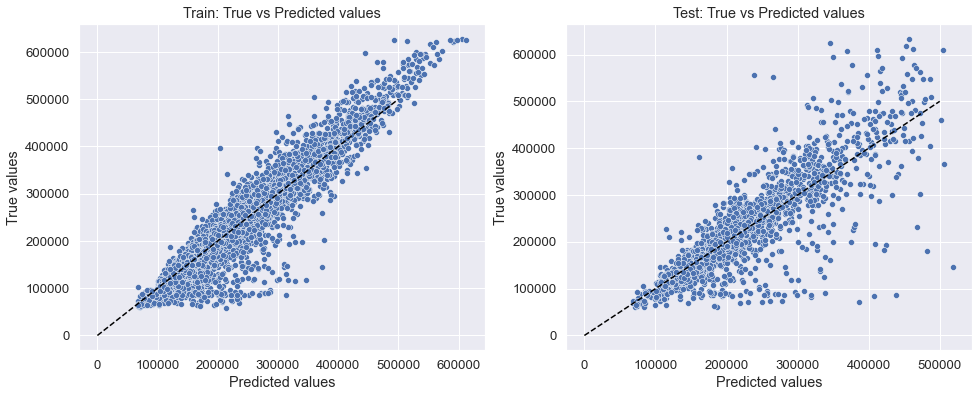

In [278]:
gb_model = GradientBoostingRegressor(n_estimators=80, max_depth=6,  random_state=42)

gb_model.fit(X_train_ext, y_train)
y_train_preds = gb_model.predict(X_train_ext)
y_test_preds = gb_model.predict(X_test_ext)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [277]:
params = {
    #    'n_estimators': [100],
    'n_estimators': [50, 60 , 70, 80, 90, 100, 110],
    'max_depth': [ 4, 5, 6, 7]
}
forest_grid = GridSearchCV(gb_model, params, scoring='r2',
                           cv=KFold(n_splits=5, random_state=42, shuffle=True),
                           n_jobs=-1)
# forest_grid.fit(X_train_ext, y_train)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

# {'max_depth': 6, 'n_estimators': 100

{'max_depth': 6, 'n_estimators': 80}
R2 на train: 0.73248


In [290]:
feature_names_full = [feature for feature in X_train_ext.columns if feature not in ['Price']]
rfe = RFE(estimator=gb_model,
          n_features_to_select=12,
          step=2)

rfe.fit(X_train_ext, y_train)
X_train_ext.columns[rfe.support_]
X_new = rfe.transform(X_train_ext)
scores = cross_val_score(gb_model, X_new, y_train, scoring='r2', cv=KFold(n_splits=5, random_state=42, shuffle=True))
print('R2: %.5f' % scores.mean())

R2: 0.73482


In [292]:
for n in range(2, 21, 1):
    rfe = RFE(gb_model, n_features_to_select=n, step=2)
    X_new = rfe.fit_transform(X_train_ext, y_train)
    scores = cross_val_score(gb_model, X_new, y_train, scoring='r2', cv=KFold(n_splits=5, random_state=42, shuffle=True))
    print('n_features_to_select: {} - R2: {:.5}'.format(n, scores.mean()))

n_features_to_select: 2 - R2: 0.67902
n_features_to_select: 3 - R2: 0.68326
n_features_to_select: 4 - R2: 0.68616
n_features_to_select: 5 - R2: 0.69198
n_features_to_select: 6 - R2: 0.70693
n_features_to_select: 7 - R2: 0.71244
n_features_to_select: 8 - R2: 0.72857
n_features_to_select: 9 - R2: 0.726
n_features_to_select: 10 - R2: 0.73299
n_features_to_select: 11 - R2: 0.73104
n_features_to_select: 12 - R2: 0.73482
n_features_to_select: 13 - R2: 0.73634
n_features_to_select: 14 - R2: 0.73294
n_features_to_select: 15 - R2: 0.73119
n_features_to_select: 16 - R2: 0.73065
n_features_to_select: 17 - R2: 0.73268
n_features_to_select: 18 - R2: 0.73288
n_features_to_select: 19 - R2: 0.73418
n_features_to_select: 20 - R2: 0.73369
